Let’s import the libraries that we are going to use for data manipulation, visualization, training the model, etc.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import pandas as pd
from math import sqrt
%matplotlib inline
import numpy as np
import csv

# avoid alert
import warnings
warnings.filterwarnings('ignore')
from scipy import stats

# Import library to preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# performace metrics libray
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# select the GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # SET A SINGLE GPU
# import library modules keras and tensorflow
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from keras import optimizers, regularizers

import keras
from tensorflow.keras import backend as K
from keras.layers import *
import tensorflow as tf
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import MaxPool1D, Activation, Conv1D, Conv2D, MaxPool2D, Flatten, TimeDistributed, Reshape
from keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional, BatchNormalization
from keras.models import Model, Input, Sequential
from keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [12]:
def transform_txt():
    with open('../../file/dataset.txt', "w") as output_file:
        with open('../../file/dataset.csv', "r") as input_file:
            [ output_file.write(" ".join(row)+'\n') for row in csv.reader(input_file)]
    output_file.close()

In [2]:
# load the dataset
dataset_throughput = pd.read_csv('../../data/data_mi.csv', header=0, low_memory=True)
#data_elapsed = pd.read_csv('../../data/data_elapsed.csv', header=0, low_memory=True)
dataset_throughput.set_index('timestamp', inplace=True)
dataset_throughput['downthpt'] = dataset_throughput['downthpt']*8
dataset_throughput['elapsed'] = data_elapsed['elapsed'].values
dataset_throughput.shape
# dataset_throughput.sort_values('timestamp', inplace=True)
# remove duplicate rows
# dataset_throughput = data.drop_duplicates(keep=False)

(12245155, 18)

In [2]:
dataset_throughput = pd.read_csv('../../data/data_mi.csv', header=0, low_memory=True)

In [4]:
dataset_throughput.head()

,minute,day,hour,iteration,request_ticks,delay,delta_sys_time,connect_time,delta_user_time,rate,received,tcp_mean_wind,elapsed,downthpt
0,2.0,15.0,0.0,0.0,1.421280e+09,0.583872,0.01,0.1472,0.00,100.0,25129.0,6.335280,0.583872,344.30844
1,2.0,15.0,0.0,1.0,1.421280e+09,0.138621,0.00,0.1472,0.01,300.0,75129.0,24.837670,0.445251,1349.87230
2,2.0,15.0,0.0,2.0,1.421280e+09,0.176049,0.00,0.1472,0.01,1200.0,300130.0,71.107630,0.621300,3864.54220
3,2.0,15.0,0.0,3.0,1.421280e+09,1.130190,0.01,0.1472,0.02,3000.0,750130.0,63.043015,1.751490,3426.24830
4,2.0,15.0,0.0,4.0,1.421280e+09,0.138882,0.02,0.1472,0.02,3000.0,750130.0,68.472450,1.612608,3721.32620


1. Feature selection

In [3]:
from yellowbrick.target import FeatureCorrelation
from sklearn.feature_selection import f_regression

In [4]:
dataset = dataset_throughput.iloc[:10000, :]
columTitles = ['delta_user_time', 'received', 'connect_time', 'rate', 'delta_sys_time', 'request_ticks', 'iteration', 'year', 'month', 'day', 'weekday', 'hour', 'minute', 'second', 'tcp_mean_wind', 'delay','elapsed','downthpt']
dataset = dataset.reindex(columns=columTitles)

In [5]:
# split into input and output
y = dataset['downthpt'].values
X = dataset.drop(columns = ['downthpt']).values
# y = y.astype('int')

In [21]:
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.rcParams['font.family'] = 'STIXGeneral'

1.1 Mutual Info-Regression

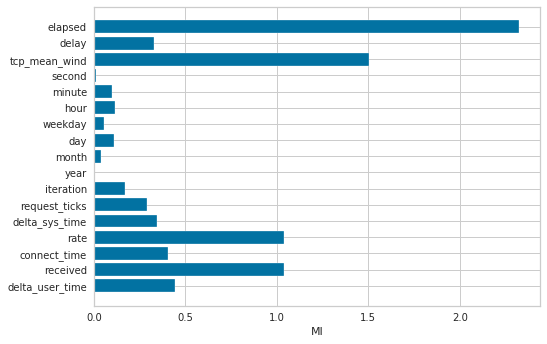

In [7]:
# Create a list of the feature names
features = dataset.columns.values[0:-1]

# Create a list of the discrete features
discrete = [False for _ in range(len(features))]
discrete[1] = True

# Instantiate the visualizer
visualizer = FeatureCorrelation(method='mutual_info-regression', labels=features)

visualizer.fit(X, y, discrete_features=discrete, random_state=1)
inf_mutual_reg = visualizer
plt.xlabel('MI')
plt.savefig('./../output_file/feat_selec_mutual_infor.pdf')
# visualizer.show()
plt.show()

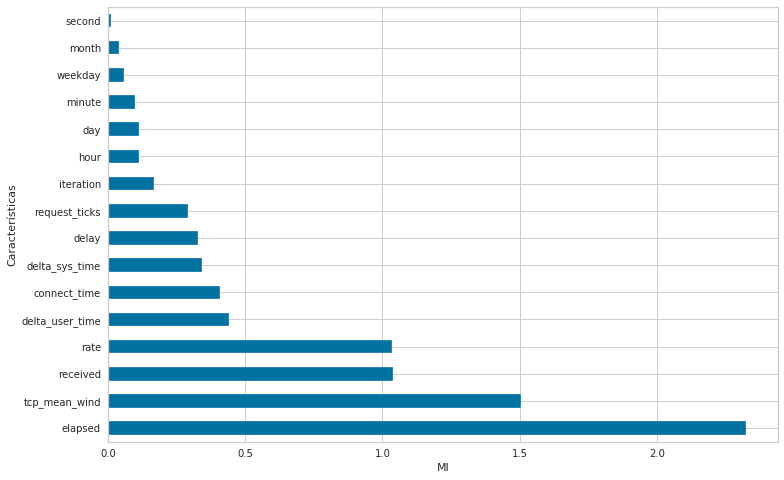

In [9]:
im = pd.Series(inf_mutual_reg.scores_, index=features)
plt.figure(figsize=(12,8))
im.nlargest(16).plot(kind='barh')
plt.ylabel('Características')
plt.xlabel('MI')
plt.savefig('./../output_file/feat_selec_mutual_infor.eps')
plt.show()

In [24]:
columnsTitles = ['year',
                 'second',
                 'month',
                 'weekday',
                 'minute',
                 'day',
                 'hour',
                 'iteration',
                 'request_ticks',
                 'delay',
                 'delta_sys_time',
                 'connect_time',
                 'delta_user_time',
                 'rate',
                 'received',
                 'tcp_mean_wind',
                 'elapsed',
                 'downthpt']
dataset_throughput = dataset_throughput.reindex(columns=columnsTitles)

1.2 Person Correlation

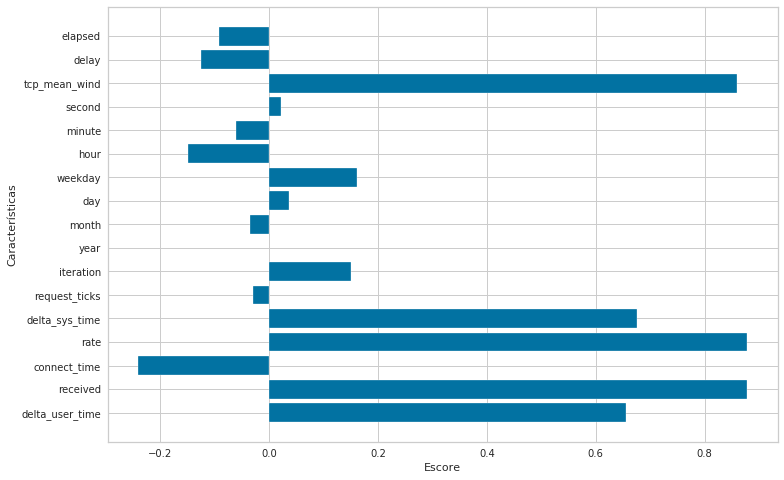

In [11]:
# Create a list of the feature names
features = dataset.columns.values[0:-1]

# Instantiate the visualizer
plt.figure(figsize=(12,8))
visualizer = FeatureCorrelation(labels=features)
visualizer.fit(X, y)        # Fit the data to the visualizer
corr_pearson = visualizer
# plt.figure(figsize=(12,8))
plt.ylabel('Características')
plt.xlabel('Escore')
plt.savefig('./../output_file/feat_selec_pearson_corr.eps')
# visualizer.show()         # Finalize and render the figure
plt.grid(True)
plt.show()

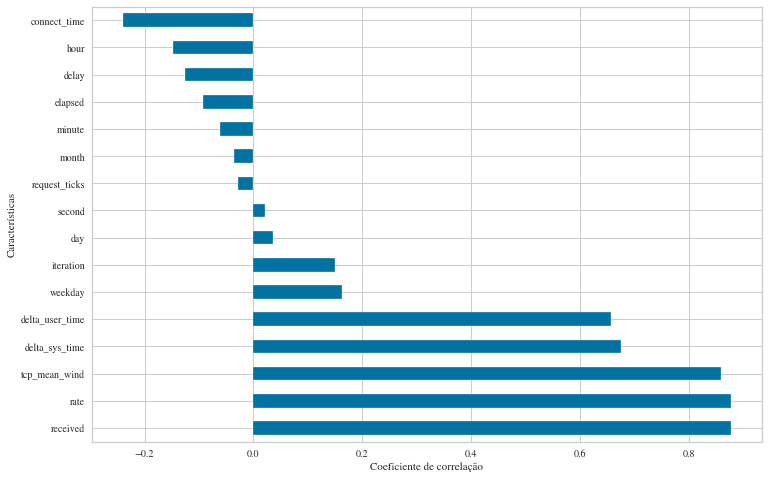

In [23]:
pc = pd.Series(corr_pearson.scores_, index=features)
plt.figure(figsize=(12,8))
pc.nlargest(17).plot(kind='barh')
plt.ylabel('Características')
plt.xlabel('Coeficiente de correlação')
plt.savefig('./../output_file/feat_selec_pearson_corr.eps')
plt.show()

In [4]:
## Pearson Correlation ##
columnsTitles = ['year',
                 'connect_time',
                 'hour',
                 'delay',
                 'elapsed',
                 'minute',
                 'month',
                 'request_ticks',
                 'second',
                 'day',
                 'iteration',
                 'weekday',
                 'delta_user_time',
                 'delta_sys_time',
                 'tcp_mean_wind',
                 'rate',
                 'received',
                 'downthpt']
dataset_throughput = dataset_throughput.reindex(columns=columnsTitles)

Here, downthpt is transformed for Mb/s

Get session downthpt up to 1MB

In [5]:
import json
import random
import seaborn as sns
from scipy import stats
sns.set(color_codes=True)

In [6]:
TRAIN_SIZE = int(len(dataset_throughput) * 0.80) # 80% train set
VALID_SIZE = int(len(dataset_throughput) * 0.90) # 10% valid and test set

In [7]:
data_train = dataset_throughput.iloc[:TRAIN_SIZE, :]
print('\nTraining Set: ', data_train.shape)

data_val = dataset_throughput.iloc[TRAIN_SIZE:VALID_SIZE, :]
print('\nValidation Set: ', data_val.shape)

data_test = dataset_throughput.iloc[VALID_SIZE:, :]
print('\nTest Set: ', data_test.shape)


Training Set:  (9796124, 14)

Validation Set:  (1224515, 14)

Test Set:  (1224516, 14)


1 MB

In [8]:
session_1mb = data_test.loc[(data_test['downthpt'] >= 1000) & (data_test['downthpt'] < 2000) & ((data_test['iteration'] == 0) | (data_test['iteration'] == 1))]

2 MB

In [9]:
session_2mb = data_test.loc[(data_test['downthpt'] >= 2000) & (data_test['downthpt'] < 3000) & ((data_test['iteration'] == 0) | (data_test['iteration'] == 1))]

3 MB

In [10]:
session_3mb = data_test.loc[(data_test['downthpt'] >= 3000) & (data_test['downthpt'] < 4000)  & ((data_test['iteration'] == 0) | (data_test['iteration'] == 1))]

In [12]:
session_1mb = session_1mb.reset_index(drop=True)
session_2mb = session_2mb.reset_index(drop=True)
session_3mb = session_3mb.reset_index(drop=True)

In [22]:
def get_session(session):
    
    connect_t = []
    session1mb = []
    prev = 0.1472
    conn = session['connect_time'].to_list() 
    
    for s in range(50):
        c = random.choice(conn)
        if c == prev:
            c = random.choice(conn)
        connect_t.append(c)
        prev = c
    
    for index in connect_t:
        session1mb.append(data_test.loc[(data_test['connect_time'].values == index)])
    
    return session1mb

In [23]:
sess = get_session(session_2mb)

In [24]:
sess

[          minute   day  hour  iteration  request_ticks     delay  \
 11124097    30.0  27.0   0.0        0.0      791566.20  0.094250   
 11124098    30.0  27.0   0.0        1.0      791566.25  0.382275   
 11124099    30.0  27.0   0.0        2.0      791566.75  1.037636   
 11124100    30.0  27.0   0.0        3.0      791568.25  0.477252   
 11124101    30.0  27.0   0.0        4.0      791569.30  1.863543   
 11124102    30.0  27.0   0.0        5.0      791572.20  2.035702   
 11124103    30.0  27.0   0.0        6.0      791573.06  1.157084   
 11124104    30.0  27.0   0.0        7.0      791575.10  1.941212   
 11124105    30.0  27.0   0.0        8.0      791579.06  3.585118   
 11124106    30.0  27.0   0.0        9.0      791579.44  0.031551   
 11124107    30.0  27.0   0.0       10.0      791579.80  1.755380   
 11124108    30.0  27.0   0.0       11.0      791581.90  0.763065   
 11124109    30.0  27.0   0.0       12.0      791583.25  3.625108   
 11124110    30.0  27.0   0.0     

In [25]:
def dict_session(sess): 
    
    store_df = []
    
    for index in range(len(sess)):
        df = sess[index]
        df['_id'] = index
        # df = df.drop(['year','second','month','weekday'], axis=1)
        # df = df.drop(['year','connect_time','delay','hour','minute','month','request_ticks','day'], axis=1)
        # columnsTitles = ['_id','second','weekday','iteration','delta_sys_time','tcp_mean_wind','rate','received','delta_user_time','downthpt']
        # df = df.reindex(columns=columnsTitles)
        df = df.to_dict('list')
        store_df.append(df)
    
    for index, value in enumerate(store_df):
        txt = str(index+1)
        x = txt.zfill(2)
        store_df[index]['_id'] = x
        x = txt.zfill(2)
        store_df[index]['connect_time'] = store_df[index]['connect_time'][0]
    return store_df

In [26]:
sess_mb = dict_session(sess)

In [27]:
sess_mb

[{'_id': '01',
  'connect_time': 0.037449762000000004,
  'day': [27.0,
   27.0,
   27.0,
   27.0,
   27.0,
   27.0,
   27.0,
   27.0,
   27.0,
   27.0,
   27.0,
   27.0,
   27.0,
   27.0,
   27.0],
  'delay': [0.09424973,
   0.38227537,
   1.0376364,
   0.47725224,
   1.8635427,
   2.0357022000000002,
   1.157084,
   1.9412116000000001,
   3.585118,
   0.031550653,
   1.7553802,
   0.763065,
   3.6251082,
   4.8714085,
   3.098388],
  'delta_sys_time': [0.0,
   0.0,
   0.0,
   0.015625,
   0.0,
   0.0,
   0.0,
   0.015625,
   0.0,
   0.0,
   0.015625,
   0.0,
   0.0,
   0.0,
   0.0],
  'delta_user_time': [0.0,
   0.015625,
   0.0,
   0.015625,
   0.015625,
   0.03125,
   0.03125,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  'downthpt': [2132.9714,
   8396.283000000001,
   9246.733,
   13502.673999999999,
   6895.8384,
   6939.6255,
   5935.7246,
   2523.5764,
   531.93286,
   2890.0325,
   2379.4570000000003,
   2988.7686,
   1007.5023,
   2175.8708,
   1253.9381]

In [28]:
def save_json(data):
    with open('../../data/store_session/session_2mbits.json', 'w', encoding='utf-8') as f:
        f.write(json.dumps(data, indent=4, sort_keys=True))

In [29]:
save_json(sess_mb)

In [3]:
"""
col = ['year','month','day','weekday','hour','minute','second','iteration','delta_user_time','received','connect_time','rate','delta_sys_time','request_ticks','tcp_mean_wind','delay','downthpt']
dataset_throughput = dataset_throughput.reindex(columns=col)
dataset_throughput.to_csv('../../file/dataset_small.txt', encoding='utf-8', index=False, header=False, sep=',', mode='w')
rawdata = np.loadtxt('../../file/dataset_small.txt', delimiter=',')
rawdata.shape
"""

"\ncol = ['year','month','day','weekday','hour','minute','second','iteration','delta_user_time','received','connect_time','rate','delta_sys_time','request_ticks','tcp_mean_wind','delay','downthpt']\ndataset_throughput = dataset_throughput.reindex(columns=col)\ndataset_throughput.to_csv('../../file/dataset_small.txt', encoding='utf-8', index=False, header=False, sep=',', mode='w')\nrawdata = np.loadtxt('../../file/dataset_small.txt', delimiter=',')\nrawdata.shape\n"

In [ ]:
# dataset_test.to_csv('../../file/dataset_test.csv', encoding='utf-8', index=False)

In [30]:
# dataset = dataset_throughput.iloc[:, 4:]
dataset = dataset_throughput.iloc[:, 4:]
dataset = dataset.astype('float32')
print(dataset.shape)
TRAIN_SIZE = int(len(dataset) * 0.60) # 60% train set
VALID_SIZE = int(len(dataset) * 0.80) # 20% valid and test set

(12245155, 14)


In [ ]:
# dataset_throughput.to_csv('../../data/dataset_orig.txt', encoding='utf-8', index=False, header=False, sep=',', mode='w')
dataset.to_csv('../../data/data_mi.csv', encoding='utf-8', index=False)
# data_small.to_csv('../../data/dataset_small.csv', encoding='utf-8', index=False, header=False, sep=',', mode='w')

In [ ]:
dataset.to_csv('../../data/data_mi.txt', encoding='utf-8', index=False, header=False, sep=',', mode='w')

In [ ]:
rawdata = np.loadtxt('../../data/dataset_mbits-Copy1.txt', delimiter=',')

In [14]:
data = pd.read_csv('../../data/dataset_small.csv', header=0, low_memory=True)

In [6]:
def one_hot_encoder(df, col):
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    for c in col:        
        v = df[c].values
        v = np.reshape(v, (-1,1))
        v = onehot_encoder.fit_transform(v)
        df[c] = v
    return df

In [23]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)        
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [17]:
def normalise_data(rawdata, normalise=2):
    rows, cols = rawdata.shape
    data = np.zeros(rawdata.shape)
    scale = np.ones(cols, dtype='float32')
    if normalise == 0: # do not normalise
        data = rawdata
        
    if normalise == 1: # same normalisation for all timeseries
        data = rawdata / np.max(rawdata)
        
    if normalise == 2: # normalise each timeseries alone. This is the default mode
        for i in range(cols):
            scale[i] = np.max(np.abs(rawdata[:, i]))
            data[:, i] = rawdata[:, i] / scale[i]
    return data

In [18]:
data = normalise_data(dataset, 2)

In [9]:
# here we going to normalize the categorical features with One Hot Encoder
# col = ['second','weekday','iteration']

In [21]:
# dataset = one_hot_encoder(dataset, col)
dataset_train = data[:TRAIN_SIZE, :]
print('\nTraining Set: ', dataset_train.shape)

dataset_val = data[TRAIN_SIZE:VALID_SIZE, :]
print('\nValidation Set: ', dataset_val.shape)

dataset_test = data[VALID_SIZE:, :]
print('\nTest Set: ', dataset_test.shape)


Training Set:  (7347093, 9)

Validation Set:  (2449031, 9)

Test Set:  (2449031, 9)


In [18]:
# dataset_val.to_csv('../../file/dataset_train.txt', encoding='utf-8', index=False, header=False, sep=',', mode='w')
# dataset_test.to_csv('../../file/dataset_test.csv', encoding='utf-8', index=False)

In [11]:
# We are going to use StandardScaler from sklearn library to scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
train_arr = scaler.fit_transform(dataset_train)
val_arr = scaler.transform(dataset_val)
test_arr = scaler.transform(dataset_test)

In [ ]:
# split into input and outputs
# train_X, train_y = train_arr[:, :-1], train_arr[:, -1]
# val_X, val_y = val_arr[:, :-1], val_arr[:, -1]
# test_X, test_y = test_arr[:, :-1], test_arr[:, -1]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

In [ ]:
# time window 
# time_steps = 5
# X_train, y_train = transform_dataset(train_arr, time_steps)
# X_test, y_test = transform_dataset(val_arr, time_steps)
# X_val, y_val = transform_dataset(test_arr, time_steps)
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Scaling the with Data RobustScaler

In [12]:
# normalization without downthpt!
f_columns = ['second',
             'weekday',
             'iteration',
             'delta_sys_time',
             'tcp_mean_wind',
             'rate',
             'received',
             'delta_user_time']

scaler_transf = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))
# f_transformer = StandardScaler()
# thrput_transformer = StandardScaler()

scaler_transf = scaler_transf.fit(dataset_train[f_columns].to_numpy())
# scaler_target = scaler_target.fit(dataset_train[['downthpt']])

dataset_train.loc[:, f_columns] = scaler_transf.transform(dataset_train[f_columns].to_numpy())
# dataset_train['downthpt'] = scaler_target.transform(dataset_train[['downthpt']])

dataset_val.loc[:, f_columns] = scaler_transf.transform(dataset_val[f_columns].to_numpy())
# dataset_val['downthpt'] = scaler_target.transform(dataset_val[['downthpt']])

dataset_test.loc[:, f_columns] = scaler_transf.transform(dataset_test[f_columns].to_numpy())
# dataset_test['downthpt'] = scaler_target.transform(dataset_test[['downthpt']])
print('\nFinished normalization...')


Finished normalization...


In [13]:
train_arr = dataset_train.values
val_arr = dataset_val.values
test_arr = dataset_test.values

In [24]:
time_steps = 5
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(dataset_train, dataset_train[:, -1], time_steps)
X_val, y_val = create_dataset(dataset_val, dataset_val[:, -1], time_steps)
X_test, y_test = create_dataset(dataset_test, dataset_test[:, -1], time_steps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7347088, 5, 9) (7347088,) (2449026, 5, 9) (2449026,)


### Modeling my LSTM with API Keras

In [25]:
def create_model(train):
    input_x = Input(shape=(train.shape[1], train.shape[2]))
    x = Conv1D(filters=64, kernel_size=2, strides=1)(input_x)
    x = Activation('relu')(x)
    x = GRU(units=64, kernel_initializer='glorot_uniform', return_sequences=True)(input_x)
    x = Activation('relu')(x)
    x = GRU(units=64, kernel_initializer='glorot_uniform', return_sequences=False)(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=1)(x)
    model = Model(inputs=input_x, outputs=x)
    return model

In [26]:
def compile_fit(train, target_train, test, target_test):
    model = create_model(train)
    model.summary()
    sgd_0 = optimizers.SGD(lr=0.001, decay=1e-2)
    sgd_1 = optimizers.SGD(lr=0.5, decay=0, nesterov=True)
    sgd_2 = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=sgd_0, metrics=['mean_absolute_error', 'mean_squared_error'])
    history = model.fit(train, target_train,
                        epochs=4, 
                        batch_size=64, 
                        validation_data=(test, target_test), 
                        shuffle=False,
                        verbose=1)
    return history, model

In [ ]:
hist, model = compile_fit(X_train, y_train, X_val, y_val)

In [ ]:
yhat = model.predict(test_X)
val_X = val_X.reshape((val_X.shape[0], val_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, val_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = np.concatenate((val_y, val_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# calculate MAE
mae = sqrt(mean_absolute_error(inv_y, inv_yhat))
print('Test MAE: %.3f' % mae)

In [35]:
# make predictions whith test set with
y_pred = model.predict(X_test)

In [41]:
trainpred = model.predict(X_train)

In [50]:
trainpred.shape

(7347088, 1)

In [ ]:
y_train_inv = scaler_target.inverse_transform(y_train.reshape(1,-1))

In [30]:
y_test_inv = scaler_target.inverse_transform(y_test.reshape(1, -1))

In [31]:
y_pred_inv = scaler_target.inverse_transform(y_pred)

In [32]:
# calculate MAE
mae = sqrt(mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print('Test MAE: %.3f' % mae)

Test MAE: 14.207


In [33]:
# calculate RMSE
mse = sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print('Test RMSE: %.3f' % mse)

Test RMSE: 454.485


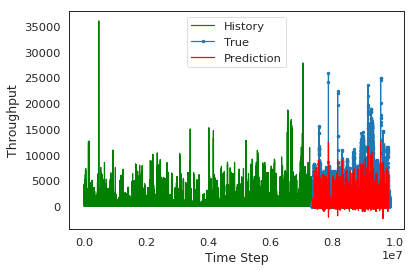

In [34]:
def plot_prediction(train, train_inv, test, test_inv, pred_inv):
    plt.plot(np.arange(0, len(train)), train_inv.flatten(), 'g', label="History")
    plt.plot(np.arange(len(train), len(train) + len(test)), test_inv.flatten(), marker='.', label="True")
    plt.plot(np.arange(len(train), len(train) + len(test)), pred_inv.flatten(), 'r', label="Prediction")
    plt.ylabel('Throughput')
    plt.xlabel('Time Step')
    plt.legend()
    # plt.savefig(os.path.join('./plots', 'prediction.eps'))
    plt.show();
plot_prediction(y_train, y_train_inv, y_test, y_test_inv, y_pred_inv)

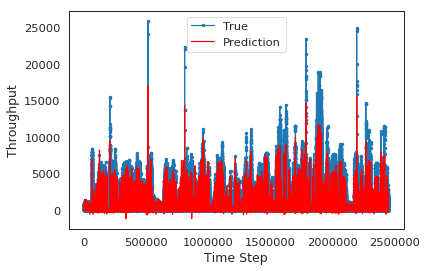

In [43]:
def plot_prediction_(pred_inv, test_inv):
    plt.plot(test_inv.flatten(), marker='.', label="True")
    plt.plot(pred_inv.flatten(), 'r', label="Prediction")
    plt.ylabel('Throughput')
    plt.xlabel('Time Step')
    plt.legend()
    # plt.savefig(os.path.join('./plots', 'prediction_detail.eps'))
    plt.show();
plot_prediction_(y_pred_inv, y_test_inv)

In [ ]:
# plot da perda do modelo

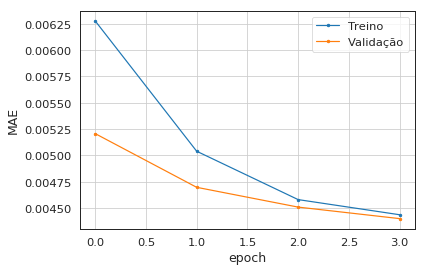

In [44]:
def plot_mae(history):
    # plot metrics
    plt.plot(history.history['mean_absolute_error'], marker='.')
    plt.plot(history.history['val_mean_absolute_error'], marker='.')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.grid()
    plt.legend(['Treino', 'Validação'], loc='best')
    # plt.savefig(os.path.join('./../plots', 'mae.eps'))
    plt.show()
    
plot_mae(hist)

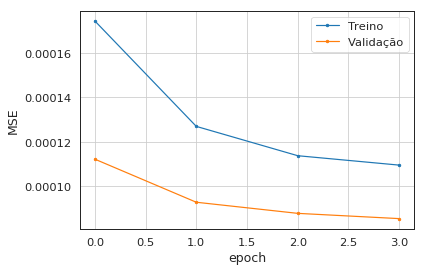

In [45]:
def plot_mse(history):
    # plot metrics
    plt.plot(history.history['mean_squared_error'], marker='.')
    plt.plot(history.history['val_mean_squared_error'], marker='.')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.grid()
    plt.legend(['Treino', 'Validação'], loc='best')
    # plt.savefig(os.path.join('./../plots', 'mse.eps'))
    plt.show()
    
plot_mse(hist)

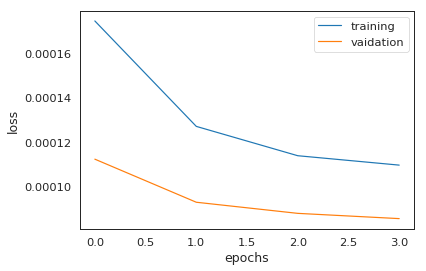

In [46]:
def plot_loss(history):
    #-----------------------------------------------------------
    # Retrieve a list of list results on training and test data
    # sets for each training epoch
    #-----------------------------------------------------------
    # loss=history.history['loss']
    # val_loss=history.history['val_loss']
    # epochs=range(len(loss)) # Get number of epochs
    
    plt.plot(history.history['loss'], label='training')
    plt.plot(history.history['val_loss'], label='vaidation')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend();
    # plt.savefig(os.path.join('./plots', 'loss.eps'))

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    # plt.plot(epochs, loss, val_loss)
    # plt.title('Training loss')
    # plt.xlabel("Epochs")
    # plt.ylabel("Loss")
    # plt.legend(["Loss"])
    
plot_loss(hist)

In [24]:
# Generate predictions
trainpred = model.predict(X_train)
testpred = model.predict(X_val)

In [25]:
# Convert predictions back to normal values
trainpred = scaler_target.inverse_transform(trainpred.reshape()) # Train Series 
Y_train = scaler_target.inverse_transform([y_train]) # Train Throughput
testpred = scaler_target.inverse_transform(testpred) # Val Series
Y_test = scaler_target.inverse_transform([y_val]) # Val Throughput
predictions = testpred

In [27]:
# calculate RMSE
trainScore = sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(Y_test[0], testpred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 254.87 RMSE
Test Score: 213.26 RMSE


In [29]:
Y_train.shape

(1, 7347088)

In [30]:
trainScore = sqrt(mean_squared_error(Y_train.flatten(), trainpred.flatten()))

In [31]:
trainScore

254.87174089503466

In [32]:
testScore = sqrt(mean_squared_error(Y_test.flatten(), testpred.flatten()))